# Machine learning the alchemical potential with the FCHL representation
- optimization of kernel width
- learning all elements together and elementwise

In [1]:
from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 20
from matplotlib import cm as cmx
import matplotlib.colors as colors
import numpy as np
import pickle
import glob

def load_obj(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def concatenate_different_sigma(small, large, newd):
    """
    concatenate dict for same element but different sigma
    """
    base = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/'
    dict_small = load_obj(base+small)
    dict_large = load_obj(base+large)
    merged_dict = {**dict_small, **dict_large}

    save_obj(merged_dict, base+newd)
    
def order_dict(unordered_dict):
    ordered_dict = dict()
    for ok in ordered_keys:
        for uk in unordered_dict.keys():
            sig_val = float(uk.split('_')[1])
            if sig_val == ok:
                ordered_dict[uk] = unordered_dict[uk]
                
    return(ordered_dict)

In [ ]:
all_alchpots = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_all.txt')

alchpots_H = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_H.txt')
alchpots_C = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_C.txt')
alchpots_N = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_N.txt')
alchpots_O = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_O.txt')

In [ ]:
datasets = [all_alchpots, alchpots_H, alchpots_C, alchpots_N, alchpots_O]
labels = [r'all $\mu$', r'$\mu_{\rm{H}}$', r'$\mu_{\rm{C}}$', r'$\mu_{\rm{N}}$', r'$\mu_{\rm{O}}$']

fig, ax = plt.subplots(1,1)
# plt.rcParams.update({'errorbar.capsize': 0})
plt.rcParams.update({'font.size': 18})

for d,l in zip(datasets, labels):
    ax.errorbar(d[:,0], d[:,1], d[:,2], label=l)

ax.set_xlabel('# Training points')
ax.set_ylabel('MAE (Ha)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

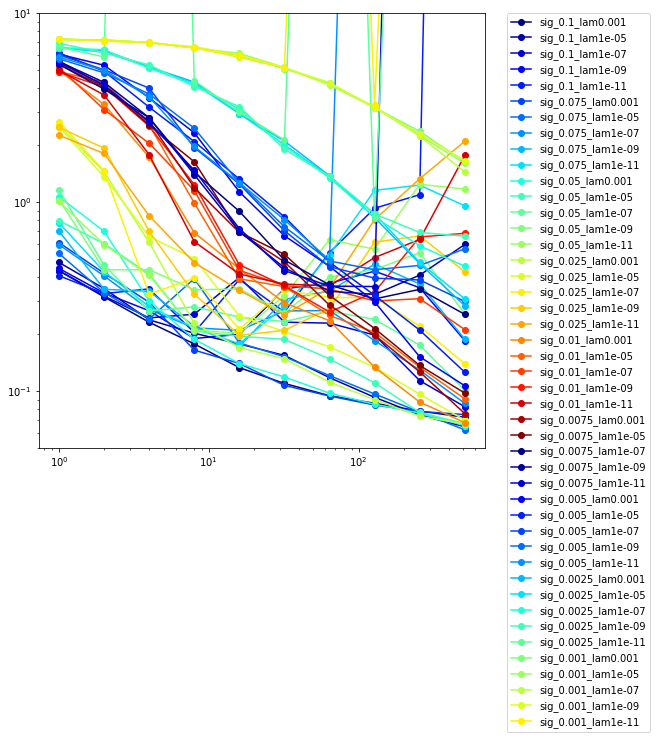

In [7]:
lcurves = load_obj('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/all_sigma_all_lam_alchpots_O.txt')
NUM_COLORS = 27#len(lcurves.keys())
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = [8.0, 8.0]
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for k in lcurves.keys():
#     if (not ('lam1e-11' in k) and (not 'lam1e-09' in k) and (not 'lam1e-07' in k) and (not 'lam1e-03' in k)):
        # r'$\sigma = {}$'.format(np.round( float(k.split('_')[1]), 4 ))
    ax.plot(lcurves[k][:,0], lcurves[k][:,1], '-o', label=k )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e-2, 1e1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### different $\lambda $ values

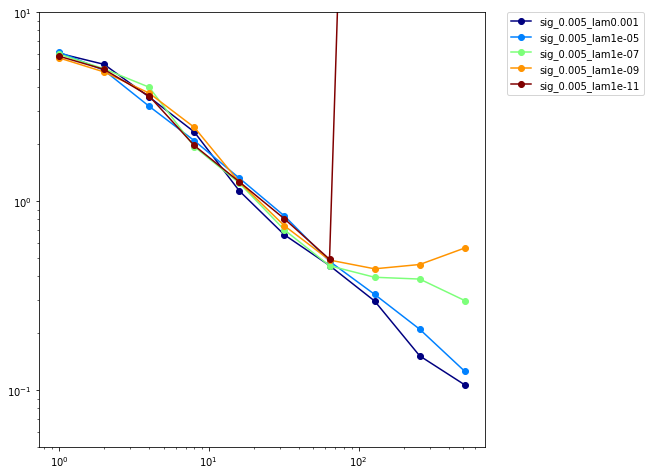

In [6]:
NUM_COLORS = 5#15
jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

fig, ax = plt.subplots(1,1)
plt.rcParams['figure.figsize'] = [8.0, 8.0]
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
for k in lcurves.keys():
#     if 'sig_0.0025' in k or 'sig_0.005' in k or 'sig_0.0075' in k:
    if 'sig_0.005' in k:
        # r'$\sigma = {}$'.format(np.round( float(k.split('_')[1]), 4 ))
        ax.plot(lcurves[k][:,0], lcurves[k][:,1], '-o', label=k )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(5e-2, 1e1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Learning curves for alchemical potential

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle
import glob

# make atomic kernel for all atoms
# for elementwise learning restrict kernel indices to the ones of the specifc element

def crossvalidate_fchl(full_kernel, labels, tr_size, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        # select random indices for training/testing
        tr_ind, test_ind = qmi.get_indices(len(labels), tr_size)
        # split labels
        labels_tr = labels[tr_ind]
        labels_test = labels[test_ind]
        # pick sub kernel for training/testing
        tr_kernel, test_kernel = qmi.split_kernel(full_kernel, tr_ind, test_ind)
        # calculate coefficients
        reg_kernel = tr_kernel + np.identity(len(tr_kernel))*lam_val
        coeffs = qml.math.cho_solve(reg_kernel, labels_tr)
        # predict labels
        labels_predicted = np.dot(test_kernel, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

# kernel path
base_path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/'
a=glob.glob(base_path+'full_kernel*')
b=glob.glob(base_path+'full_kernel*_lam')
kernel_paths = list(set(a)-set(b))
# kernel_paths = ['full_kernel_alchoff_sig0.01', 'full_kernel_alchoff_sig0.001', 'full_kernel_alchoff_sig0.0001']

In [ ]:
# calculation of learning curves
sigmas = []
for i in kernel_paths:
    sigmas.append(i.split('_')[-1][3:])

lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 11, 12, base=2).astype(int)

for sigma, kernel_path in zip(sigmas, kernel_paths):
    error_cv = []
    error_std = []
    # load kernel
    kernel = np.loadtxt(kernel_path)
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = crossvalidate_fchl(kernel, alch_pots, tr_size, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
sig_val = 0.1
lam_val = 1e-5
num_cv = 3
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]
path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_all_alchpots_small_sigmas.txt'
sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

In [ ]:
# save dictionary of learning curves at all sigmas
fname = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/all_sigma_all2'
save_obj(lcurves, fname)

#### $\sigma$ and $\lambda$ optimization

In [3]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')
base_path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/'

kernel_paths = []
for s in [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.0050, 0.0025, 0.001]:
    kernel_paths.append(f'{base_path}full_kernel_alchoff_sig{s}')

In [5]:
# best sigmas
sigmas = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.0050, 0.0025, 0.001]
lam_vals = [1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
num_cv = 10

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 11, 12, base=2).astype(int)

for sigma, kernel_path in zip(sigmas, kernel_paths):
    # load kernel
    kernel = np.loadtxt(kernel_path)

    for lam_val in lam_vals:
        error_cv = []
        error_std = []
        # calculate error for every training point size
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate_fchl(kernel, alch_pots, tr_size, lam_val, num_cv)
            error_cv.append(err)
            error_std.append(err_std)

        lcurves[f'sig_{sigma}_lam{lam_val}'] = np.array([set_sizes, error_cv, error_std]).T
    
# save dictionary of learning curves at all sigmas
fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/all_sigma_all_lam'
save_obj(lcurves, fname)

### Learning curves for alchemical potential of single elements

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle
import glob

def crossvalidate_fchl(full_kernel, labels, tr_size, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        # select random indices for training/testing
        tr_ind, test_ind = qmi.get_indices(len(labels), tr_size)
        # split labels
        labels_tr = labels[tr_ind]
        labels_test = labels[test_ind]
        # pick sub kernel for training/testing
        tr_kernel, test_kernel = qmi.split_kernel(full_kernel, tr_ind, test_ind)
        # calculate coefficients
        reg_kernel = tr_kernel + np.identity(len(tr_kernel))*lam_val
        coeffs = qml.math.cho_solve(reg_kernel, labels_tr)
        # predict labels
        labels_predicted = np.dot(test_kernel, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [ ]:
# kernel path
base_path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/'
a=glob.glob(base_path+'full_kernel*')
b=glob.glob(base_path+'full_kernel*_lam')
kernel_paths = list(set(a)-set(b))

In [ ]:
sigmas = [float(k.split('_')[-1][3:]) for k in kernel_paths]
lam_val = 1e-5
num_cv = 10

for charge in idc_by_charge.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = get_tr_size(len(el_alch_pots[charge]))
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma, kernel_path in zip(sigmas, kernel_paths):

        # calculate error for every training point size
        error_cv = []
        error_std = []
        # load kernel
        kernel = np.loadtxt(kernel_path)
        # select subkernel for element
        el_kernel = qmi.select_sub_matrix(kernel, idc_by_charge[charge], idc_by_charge[charge])
        el_kernel = el_kernel.reshape((el_kernel.shape[0], el_kernel.shape[2]))
        # calculate error for every training point size
        for idx, tr_size in enumerate(set_sizes):
            err, err_std = crossvalidate_fchl(el_kernel, el_alch_pots[charge], tr_size, lam_val, num_cv)
            error_cv.append(err)
            error_std.append(err_std)

        lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T
        
    
    # save best learning curve
    lowest_error = (None, None)
    for k in lcurves.keys():
        if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
            lowest_error = (k, np.amin(lcurves[k][:,1]))
    save_data = lcurves[lowest_error[0]]

    # filename
    el_symbol = get_element_symbol(charge)
    path = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/best_{el_symbol}.txt'

    sig_val = lowest_error[0].split('_')[1]
    header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
    np.savetxt(path, save_data, delimiter='\t', header=header)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/all_sigma_{el_symbol}.txt'
    save_obj(lcurves, fname)

### Learning curves for alchemical potential of single elements optimize $\sigma$ and $\lambda$

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle
import glob

def crossvalidate_fchl(full_kernel, labels, tr_size, lam, num_cv):
    errors = []
    for cv in range(num_cv):
        # select random indices for training/testing
        tr_ind, test_ind = qmi.get_indices(len(labels), tr_size)
        # split labels
        labels_tr = labels[tr_ind]
        labels_test = labels[test_ind]
        # pick sub kernel for training/testing
        tr_kernel, test_kernel = qmi.split_kernel(full_kernel, tr_ind, test_ind)
        # calculate coefficients
        reg_kernel = tr_kernel + np.identity(len(tr_kernel))*lam_val
        coeffs = qml.math.cho_solve(reg_kernel, labels_tr)
        # predict labels
        labels_predicted = np.dot(test_kernel, coeffs)
        errors.append((np.abs(labels_predicted - labels_test)).mean())
    errors = np.array(errors)
    return(errors.mean(), errors.std())

def save_obj(obj, fname ):
    with open(fname, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def get_tr_size(data_size):
    """
    largest number of training points is roughly 90% of complete data (largest multiple of 2 that is <= 90%)
    """
    largest_set = int(np.log2(data_size*0.9))
    tr_size = np.logspace(0, largest_set, largest_set+1, base=2).astype(int)
    return(tr_size)

def get_element_symbol(Z):
    if int(Z) == 1:
        return('H')
    elif int(Z) == 6:
        return('C')
    elif int(Z) == 7:
        return('N')
    elif int(Z) == 8:
        return('O')
    else:
        raise ValueError('Symbol for given charge not available')

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())
alch_pots = qmi.generate_label_vector(data, molecule_size.sum(), value='alch_pot')

# split up alchemical potential by element
charges = qmi.generate_label_vector(data, molecule_size.sum(), value='charge')
idc_by_charge = qmi.partition_idx_by_charge(charges)

el_alch_pots = dict()
for k in idc_by_charge.keys():
    el_alch_pots[k] = alch_pots[idc_by_charge[k]]

In [ ]:
# kernel path
base_path = '/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/FCHL/'
a=glob.glob(base_path+'full_kernel*')
b=glob.glob(base_path+'full_kernel*_lam')
kernel_paths = list(set(a)-set(b))

kernel_paths = []
for s in [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.0050, 0.0025, 0.001]:
    kernel_paths.append(f'{base_path}full_kernel_alchoff_sig{s}')

In [ ]:
# best sigmas
sigmas = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.0050, 0.0025, 0.001]
lam_vals = [1e-3, 1e-5, 1e-7, 1e-9, 1e-11]
num_cv = 10

for charge in el_alch_pots.keys():
    lcurves = dict()

    # define number of training points for which MAE is calculated
    set_sizes = get_tr_size(len(el_alch_pots[charge]))
    
    # special for H
#     set_sizes = np.concatenate((set_sizes, np.array([3300])))

    for sigma, kernel_path in zip(sigmas, kernel_paths):
        # load kernel
        kernel = np.loadtxt(kernel_path)
        # select subkernel for element
        el_kernel = qmi.select_sub_matrix(kernel, idc_by_charge[charge], idc_by_charge[charge])
        el_kernel = el_kernel.reshape((el_kernel.shape[0], el_kernel.shape[2]))
        
        for lam_val in lam_vals:
            error_cv = []
            error_std = []
            # calculate error for every training point size
            for idx, tr_size in enumerate(set_sizes):
                err, err_std = crossvalidate_fchl(el_kernel, el_alch_pots[charge], tr_size, lam_val, num_cv)
                error_cv.append(err)
                error_std.append(err_std)

            lcurves[f'sig_{sigma}_lam{lam_val}'] = np.array([set_sizes, error_cv, error_std]).T
    
    # filename
    el_symbol = get_element_symbol(charge)

    # save dictionary of learning curves at all sigmas
    fname = f'/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/lcurves_alch_pot/fchl/all_sigma_all_lam_alchpots_{el_symbol}.txt'
    save_obj(lcurves, fname)